In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

In [2]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal1(state, index):
    return(state + 0.1 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



In [3]:
# test the  Test function
xs = np.arange(-2.0, 2.0, 0.001)
shuffle(xs) # so noise is random

exs = np.expand_dims(xs, axis=1)
print(exs.shape)

#e = TestFnSign(proposal1, xs.size)
e = TestFn(proposal1, xs.size, 100)



(4000, 1)


In [4]:

%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#%time ys = [e.cached_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
#%time ys = [e.user_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))

# caching has a big overhead!!


Wall time: 1.21 s
Wall time: 4 ms


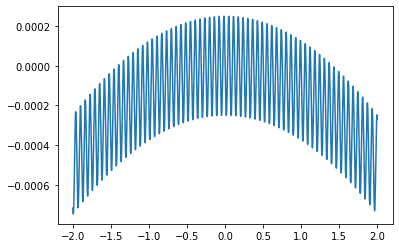

In [5]:
# example single scenario = corrupted log Gaussian density (if we're using TestFn)
plt.figure()
xs = np.arange(-2.0, 2.0, 0.001)
exs = np.expand_dims(xs, axis=1)
ys = [e.evaluate(x, 0) for x in exs]
plt.gca().plot(xs, ys)

In [6]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults
#HINTS payoff comes for large num scenarios > 1000
# checked regular MCMC is accurate (1 level, lbf = 6)
if True:
    args.levels = 5
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 5000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 1024
    args.design = np.array([NUM_SCENARIOS])
    iterations = 42094# need to match actual evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries

# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.grad_scale = 100.0 # for first TestFn


print(args.__dict__)

1024
{'levels': 5, 'design': array([1, 4, 4, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'grad_scale': 100.0}


In [7]:
# CHOOSE YOUR OWN TEST FUNCTION HERE!

g = TestFn(proposal1, NUM_SCENARIOS, args.additive, args.grad_scale)
#g = TestFnSign(proposal1, NUM_SCENARIOS, args.additive)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)


RESET
5
[   1    4   16   64  256 1024]
1024
[1. 1. 1. 1. 1. 1.]
[-0.47379303]


In [8]:
# FAR FASTER WITHOUT CACHING FOR SIMPLE TEST TASKS
# SO IF WE CACHE, SHOULD BE BIG CHUNKS. OR WE AVOID MEMOIZING
# e.g. JUST KEEP LUT PER STATE (i.e. at each level)

#cache.clear()
#print(cache.stats(enable=True, reset = True))
for t in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1, hmc.acceptances, hmc.rejections)
        #print(cache.stats(enable=True, reset = True))


500 [511887 127910  31886   7779   1639    305] [113  90 114 221 361 195]
1000 [1023776  255845   63780   15585    3300     615] [224 155 220 415 700 385]
1500 [1535647  383748   95662   23370    4978     946] [ 353  252  338  630 1022  554]
2000 [2047520  511660  127535   31141    6640    1265] [ 480  340  465  859 1360  735]
2500 [2559419  639562  159420   38917    8312    1567] [ 581  438  580 1083 1688  933]
3000 [3071285  767466  191315   46723    9976    1879] [ 715  534  685 1277 2024 1121]
3500 [3583164  895379  223197   54509   11658    2185] [ 836  621  803 1491 2342 1315]
4000 [4095049 1023312  255054   62295   13352    2516] [ 951  688  946 1705 2648 1484]
4500 [4606941 1151225  286941   70054   15000    2842] [1059  775 1059 1946 3000 1658]
5000 [5118815 1279146  318828   77871   16687    3167] [1185  854 1172 2129 3313 1833]


In [9]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[  0.   0.   0.   0.   0.   2.   0.   3.   0.   3.   8.  14.  11.  15.
  20.  29.  41.  53.  56.  72. 101. 111. 146. 137. 151. 169. 196. 213.
 216. 260. 229. 228. 240. 201. 216. 212. 245. 229. 194. 176. 137. 111.
  93. 101.  82.  62.  57.  38.  34.  27.  17.  15.   9.   9.   6.   2.
   0.   3.   0.   0.   0.   0.   0.   0.]
[5118815 1279146  318828   77871   16687    3167]
[1185  854 1172 2129 3313 1833]
[0.99976855 0.99933281 0.9963375  0.9733875  0.83435    0.6334    ]


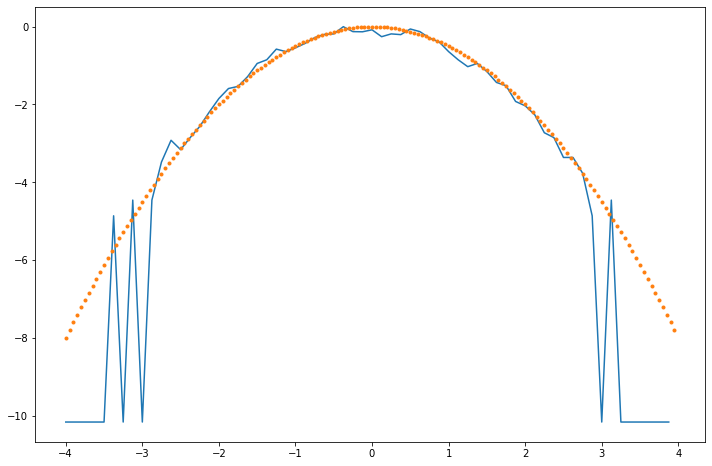

In [10]:


#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)

plt.plot(xs1, logprob - np.max(logprob))
xs = np.arange(-nsd, nsd, nsd/80.0)
shuffle(xs) # so noise is not correlated with term
exs = np.expand_dims(xs, axis=1)

#hxs = [HashableItem(np.array([x])) for x in xs]

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate(x, i) for i in range(NUM_SCENARIOS)]) for x in exs]
else:
    ys = [sum([g.evaluate(x, i)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in exs]

plt.plot(xs, ys,'.')


In [11]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewwer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 61,440,000; Missed cache: 43,099,979; Miss rate: 70%


In [12]:
#iterations = int(g.counter/NUM_SCENARIOS) # for MCMC
iterations = int(43104413/NUM_SCENARIOS) # for MCMC
iterations

42094

In [13]:
# example of how to use line profiler
if False:
    from line_profiler import LineProfiler
    lp = LineProfiler()
    lp.add_function(g.__call__)
    lp.add_function(g.cached_evaluate)
    lp_wrapper = lp(hmc.hints)
    lp_wrapper(state, args.levels)
    #lp_wrapper = lp(g.evaluate)
    #lp_wrapper(np.array([0.123456789]), args.levels)
    lp.print_stats()



In [14]:
# TO DO 
# pytorch test function
# state is model
# proposal is grad descent + noise (Langevin or HMC style) on minibatch
# SEE TorchModelScratch